In [1]:
from mogp_emulator.ExperimentalDesign import LatinHypercubeDesign
import matplotlib.pyplot as plt
plt.rcParams.update({
                     'font.family':'Times New Roman',
                     })
import numpy as np

from dgpsi import *
from sklearn.model_selection import train_test_split

## 1D Case

In [2]:
def test_f(x):
    return np.sin(2*x) + np.cos(3*x) + 0.1*np.sin(5*x)
def gradient_test_f(x):
    return 2*np.cos(2*x) - 3*np.sin(3*x) + 0.5*np.cos(5*x)


lhd = LatinHypercubeDesign([(-np.pi,np.pi)])

x_train = lhd.sample(15)
y_train = np.array(test_f(x_train))
gp_emu = gp(x_train, y_train, kernel(length=np.array([1]), name='matern2.5', scale_est=True))
gp_emu.train()

### GP Emulator

In [3]:
grid_eval_grid = np.linspace(-np.pi, np.pi, 100)

Z = test_f(grid_eval_grid)
grad_eval = gradient_test_f(grid_eval_grid)

pred_mu, _ = gp_emu.predict(grid_eval_grid[:,None])
grad_pred, grad_pred_var = grad_gp(grid_eval_grid[:,None], gp_emu)

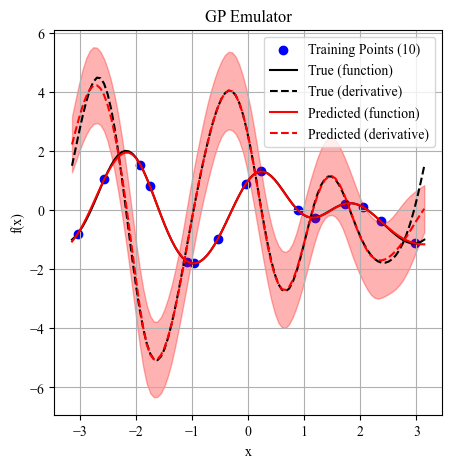

In [4]:
fig, ax = plt.subplots(figsize=(5, 5))

ax.scatter(x_train, y_train, color='blue', label='Training Points (10)')


ax.plot(grid_eval_grid, Z, color='black', label='True (function)')
ax.plot(grid_eval_grid, grad_eval, linestyle='--', color='black', label='True (derivative)')


ax.plot(grid_eval_grid, pred_mu, color='red', label='Predicted (function)')
ax.plot(grid_eval_grid, grad_pred, linestyle='--', color='red', label='Predicted (derivative)')
ax.fill_between(grid_eval_grid, (grad_pred - grad_pred_var)[:,0], 
                                (grad_pred + grad_pred_var)[:,0], color='red', alpha=0.3)
plt.xlabel('x')
plt.ylabel('f(x)')
plt.title('GP Emulator')

plt.legend()
plt.grid()
plt.show()

### DGP Emulator

In [5]:
y_train = np.array(test_f(x_train))
layer1=[kernel(length=np.array([1]),name='sexp', scale_est=True)]
layer2=[kernel(length=np.array([1]),name='sexp', scale_est=True)]
all_layer=combine(layer1,layer2)
m=dgp(x_train,y_train,all_layer)
m.train(N=500)
final_layer_obj=m.estimate()
emu=emulator(final_layer_obj,N=1)

Iteration 500: Layer 2: 100%|██████████| 500/500 [00:02<00:00, 201.51it/s]


In [6]:
pred_mu, pred_var = emu.predict(grid_eval_grid[:,None], full_layer=True)
grad_pred, grad_pred_var = grad_dgp(grid_eval_grid[:,None], emu, return_variance=True)

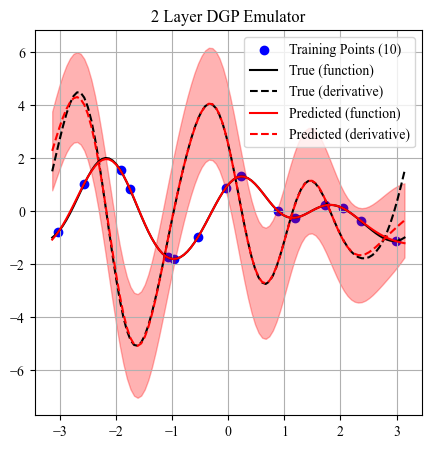

In [7]:
fig, ax = plt.subplots(figsize=(5, 5))

ax.scatter(x_train, y_train, color='blue', label='Training Points (10)')
ax.plot(grid_eval_grid, Z, color='black', label='True (function)')
ax.plot(grid_eval_grid, grad_eval, linestyle='--', color='black', label='True (derivative)')


ax.plot(grid_eval_grid, pred_mu[1], color='red', label='Predicted (function)')
ax.plot(grid_eval_grid, grad_pred, linestyle='--', color='red', label='Predicted (derivative)')
ax.fill_between(grid_eval_grid, (grad_pred - grad_pred_var[:,0])[:,0],
                                (grad_pred + grad_pred_var[:,0])[:,0], color='red', alpha=0.3)
plt.title('2 Layer DGP Emulator')

plt.legend()
plt.grid()
plt.show()

## 2D Case

In [8]:
def finite_differecing(x_star, emulator, h=1e-6, num=3):
    assert len(x_star.shape) == 1
    assert num % 2 == 1, "num must be odd"
    D = x_star.shape[0]
    eval_grid = [np.linspace(x_star[i] - h, x_star[i] + h, num=num) for i in range(D)]
    eval_grid = np.meshgrid(*eval_grid)
    eval_grid = np.stack([eval_grid[i].flatten() for i in range(D)], axis=-1)
    pred_mu, _ = emulator.predict(eval_grid)
    pred_mu = pred_mu.reshape(num, num)
    grad = np.array(np.gradient(pred_mu, *([h] * D)))
    return grad[:, num // 2, num // 2]

In [9]:
# Define the benchmark function
def relu(x):
    return np.maximum(0, x)

def test_f(x):
    x1, x2 = x[..., 0], x[..., 1]
    return np.sin(1/((0.7*x1+0.3)*(0.7*x2+0.3)))
# Define the closed-form gradient function
def gradient_test_f(x):
    x1, x2 = x[..., 0], x[..., 1]
    g = (0.7 * x1 + 0.3) * (0.7 * x2 + 0.3)  # Simplify the denominator term

    # Partial derivatives with respect to x1 and x2
    df_dx = - np.cos(1 / g) * (0.7 * (0.7 * x2 + 0.3)) / g**2
    df_dy = - np.cos(1 / g) * (0.7 * (0.7 * x1 + 0.3)) / g**2
    return np.array([df_dx, df_dy])

# visualize uncertainty ellipse
def plot_ellipse(center, Sigma, ax, color='blue', rescale_factor=1, legend=True):
    # Eigen decomposition
    eigenvalues, eigenvectors = np.linalg.eigh(Sigma/rescale_factor)
    order = eigenvalues.argsort()[::-1]
    eigenvalues, eigenvectors = eigenvalues[order], eigenvectors[:, order]

    # Generate the ellipsoid (ellipse) points
    theta = np.linspace(0, 2 * np.pi, 100)
    circle = np.array([np.cos(theta), np.sin(theta)])

    # Scale and rotate the unit circle to create the ellipse
    ellipse = eigenvectors @ np.diag(np.sqrt(eigenvalues)) @ circle

    # Plot
    x = ellipse[0, :]/50 + center[0]
    y = ellipse[1, :]/50 + center[1]
    if legend:
        ax.plot(x, y, color=color, linestyle='--', label='Uncertainty ellipse')
    else:
        ax.plot(x, y, color=color, linestyle='--')

In [10]:
# From the paper https://epubs.siam.org/doi/10.1137/19M124438X
x1=np.array([0,.02,.075,.08,.14,.15,.155,.156,.18,.22,.29,.32,.36, .37,.42,.5,.57,.63,.72,.785,.8,.84,.925,1,1,0])
x2=np.array([.29,.02,.12,.58,.38,.87,.01,.12,.22,.08,.34,.185,.64, .02,.93,.15,.42,.71,1,0,.21,.5,.785,.21,1,1])
x_train = np.stack([x1, x2], axis=-1)

y_train = np.array(test_f(x_train))

# GP emulator with grid serach over length scale
candidate_length = [0.1, 0.5, 1, 2, 5, 10]
gs_x_train, gs_x_eval, gs_y_train, gs_y_eval = train_test_split(x_train, y_train, 
                                                                test_size=0.3, 
                                                                random_state=17)
best_loss = np.inf
for l in candidate_length:
    gp_emu = gp(gs_x_train, gs_y_train[:,None], kernel(length=np.array([l]), name='sexp', scale_est=True))
    gp_emu.train()
    pred_mu_gp, _ = gp_emu.predict(gs_x_eval)
    loss = np.mean((pred_mu_gp - gs_y_eval)**2)
    if loss < best_loss:
        best_loss = loss
        best_length = l
print(f"[INFO] Best length scale: {best_length}")
gp_emu = gp(x_train, y_train[:,None], kernel(length=np.array([best_length]), name='sexp', scale_est=True))
gp_emu.train()


# DGP emulator
layer1=[kernel(length=np.array([1]),name='sexp', scale_est=True),
        kernel(length=np.array([1]),name='sexp', scale_est=True)]
layer2=[kernel(length=np.array([1]),name='sexp', scale_est=True)]
all_layer=combine(layer1,layer2)
m=dgp(x_train,y_train[:,None],all_layer)
m.train(N=500)
final_layer_obj=m.estimate()
emu=emulator(final_layer_obj,N=50)

grid_eval_func = np.linspace(0, 1, 50)
grid_eval_func = np.meshgrid(grid_eval_func, grid_eval_func)
grid_eval_func = np.stack([grid_eval_func[0].flatten(), grid_eval_func[1].flatten()], axis=-1)
Z = test_f(grid_eval_func)  
pred_mu_gp, _ = gp_emu.predict(grid_eval_func)

full_pred_mu, _ = emu.predict(grid_eval_func, full_layer=True)
pred_w_mu, pred_mu = full_pred_mu

[INFO] Best length scale: 0.1


Iteration 500: Layer 2: 100%|██████████| 500/500 [00:03<00:00, 131.91it/s]


In [11]:
grid_eval_grid = np.linspace(0.1, 0.9, 9)
grid_eval_grid = np.meshgrid(grid_eval_grid, grid_eval_grid)
grid_eval_grid = np.stack([grid_eval_grid[0].flatten(), grid_eval_grid[1].flatten()], axis=-1)
grad_eval = gradient_test_f(grid_eval_grid)

In [12]:
grad_pred_gp, grad_pred_var_gp = grad_gp(grid_eval_grid, gp_emu)


grad_pred, grad_pred_var = grad_dgp(grid_eval_grid, emu, return_variance=True)
grad_pred_finite_diff = np.array([finite_differecing(grid_eval_grid[i], emu) for i in range(81)])

#### Finiting Differencing - DGP results

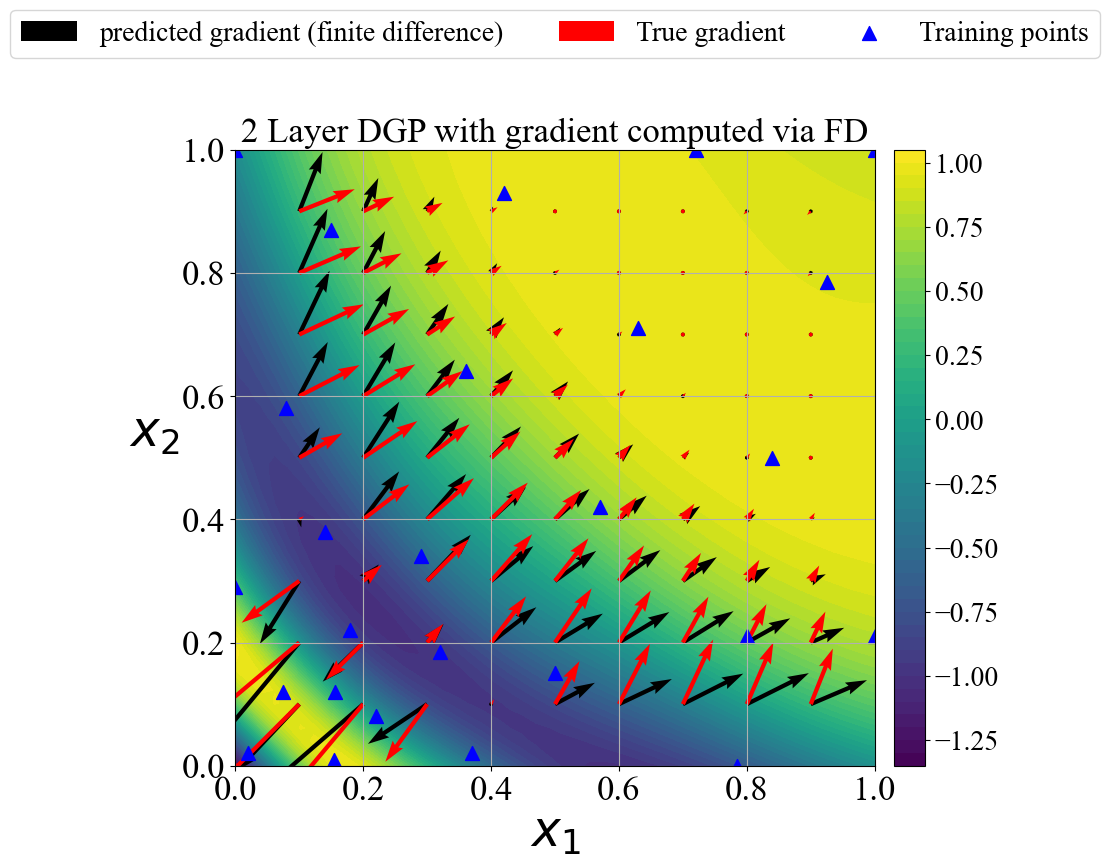

In [13]:
fig, ax = plt.subplots(figsize=(10, 8), dpi=100)


colorbar_1 = ax.contourf(grid_eval_func[:,0].reshape(50,50), 
                         grid_eval_func[:,1].reshape(50,50), 
                         pred_mu.reshape(50,50), levels=50)
cbar = fig.colorbar(colorbar_1, 
                    ax=ax, 
                    pad=0.025, 
                    aspect=20)
cbar.ax.tick_params(labelsize=20) 
ax.quiver(grid_eval_grid[:, 0], grid_eval_grid[:, 1], 
          grad_pred_finite_diff[:,0], grad_pred_finite_diff[:,1], 
          label="predicted gradient (finite difference)")
ax.quiver(grid_eval_grid[:, 0], grid_eval_grid[:, 1],
          grad_eval[0], grad_eval[1], color='red', label='True gradient')


ax.set_xlabel(r"$x_1$", fontsize=35)
ax.set_ylabel(r"$x_2$", fontsize=35, rotation=0, labelpad=20)
ax.grid()
plt.tick_params(axis='both', which='major', labelsize=25)
ax.scatter(x_train[:, 0], x_train[:, 1], color='blue', marker='^', s=100, label='Training points')
plt.title('2 Layer DGP with gradient computed via FD', fontsize=25)
plt.legend(fontsize=20, bbox_to_anchor=(0.5, 1.25), loc='upper center', ncol=3)

plt.show()


#### GP Results

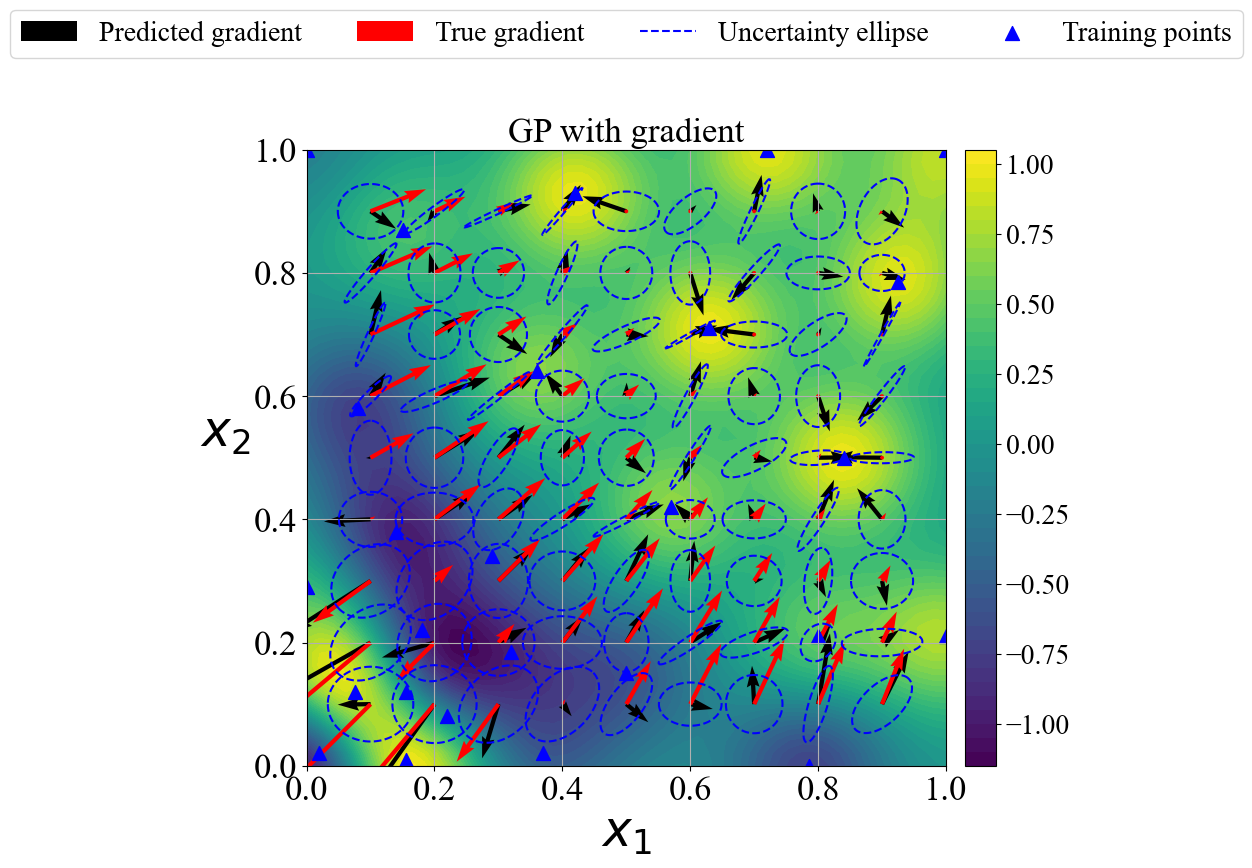

In [14]:
fig, ax = plt.subplots(figsize=(10, 8), dpi=100)

colorbar_1 = ax.contourf(grid_eval_func[:,0].reshape(50,50), 
                          grid_eval_func[:,1].reshape(50,50), 
                        pred_mu_gp.reshape(50,50), levels=50)
cbar = fig.colorbar(colorbar_1, 
                    ax=ax, 
                    pad=0.025, 
                    aspect=20)
cbar.ax.tick_params(labelsize=20) 
ax.quiver(grid_eval_grid[:, 0], grid_eval_grid[:, 1], 
            grad_pred_gp[:, 0], grad_pred_gp[:, 1], label='Predicted gradient')
ax.quiver(grid_eval_grid[:, 0], grid_eval_grid[:, 1],
          grad_eval[0], grad_eval[1], color='red', label='True gradient')

c = 0
for i in range(81):
    if np.nan in grad_pred_var_gp[i]:
        continue
    elif np.all(grad_pred_var_gp[i] > 1100):
        continue
    else:
        if c==0:
            plot_ellipse(grid_eval_grid[i], 
                         grad_pred_var_gp[i], 
                         ax, 
                         rescale_factor=1, 
                         legend=True)
        else:
            plot_ellipse(grid_eval_grid[i], 
                         grad_pred_var_gp[i], 
                         ax, 
                         rescale_factor=1, 
                         legend=False)
        c += 1
ax.set_xlabel(r"$x_1$", fontsize=35)
ax.set_ylabel(r"$x_2$", fontsize=35, rotation=0, labelpad=20)
ax.grid()
plt.tick_params(axis='both', which='major', labelsize=25)
ax.scatter(x_train[:, 0], x_train[:, 1], color='blue', marker='^', s=100, label='Training points')
plt.title('GP with gradient', fontsize=25)
plt.legend(fontsize=20, bbox_to_anchor=(0.5, 1.25), loc='upper center', ncol=4)
plt.show()


#### Our proposed - DGP results

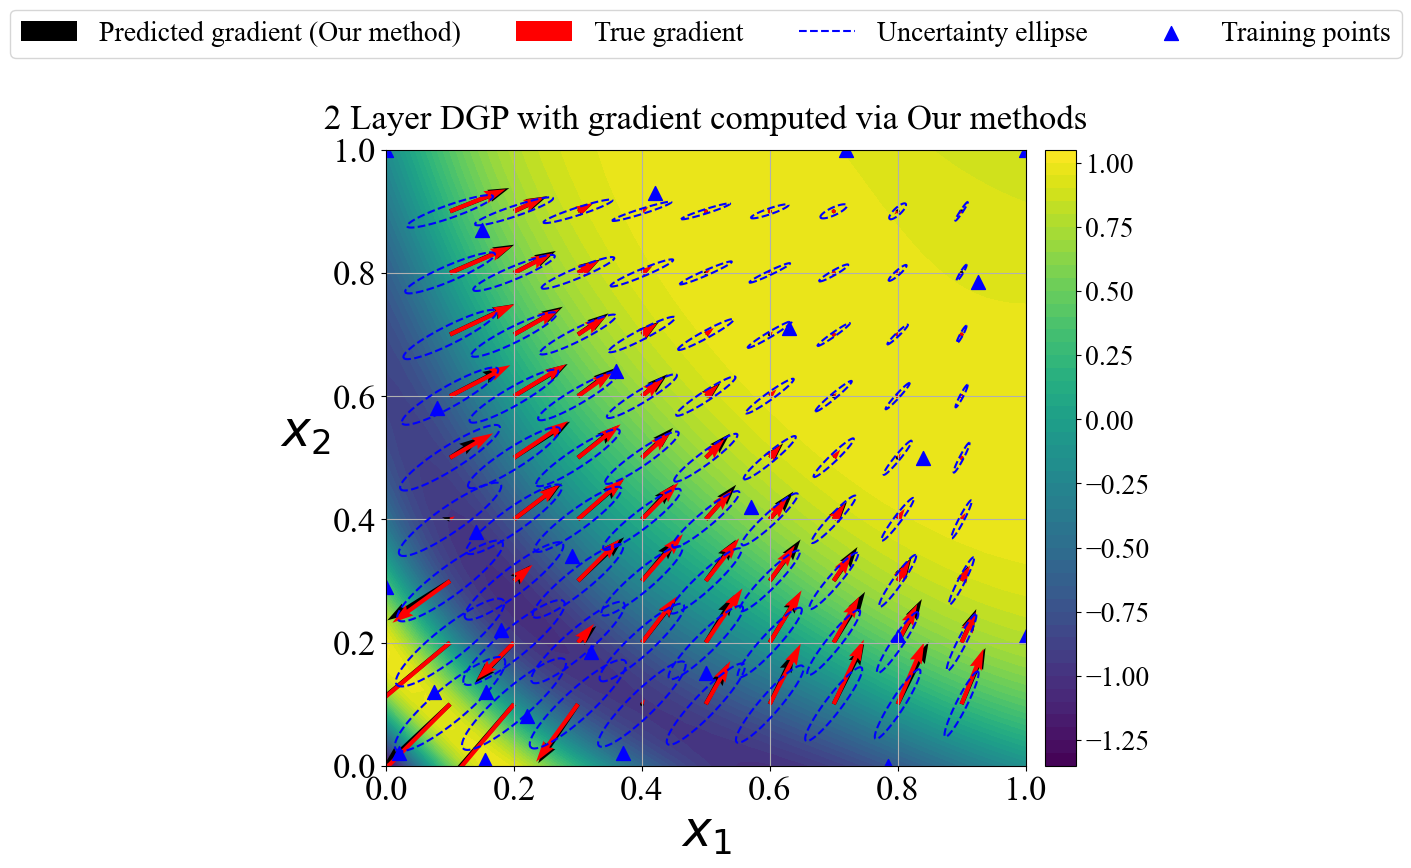

In [15]:
fig, ax = plt.subplots(figsize=(10, 8), dpi=100)

colorbar_1 = ax.contourf(grid_eval_func[:,0].reshape(50,50), 
                         grid_eval_func[:,1].reshape(50,50), 
                         pred_mu.reshape(50,50), levels=50)
cbar = fig.colorbar(colorbar_1, 
                    ax=ax, 
                    pad=0.025, 
                    aspect=20)
cbar.ax.tick_params(labelsize=20) 

ax.quiver(grid_eval_grid[:, 0], grid_eval_grid[:, 1], 
            grad_pred[:, 0], grad_pred[:, 1], label='Predicted gradient (Our method)')
         
ax.quiver(grid_eval_grid[:, 0], grid_eval_grid[:, 1],
          grad_eval[0], grad_eval[1], color='red', label='True gradient')

c = 0
for i in range(81):
    if np.nan in grad_pred_var[i]:
        continue
    elif np.all(grad_pred_var[i] > 1100):
        continue
    else:
        if c==0:
            plot_ellipse(grid_eval_grid[i], 
                         grad_pred_var[i], 
                         ax, 
                         rescale_factor=3, 
                         legend=True)
        else:
            plot_ellipse(grid_eval_grid[i], 
                         grad_pred_var[i], 
                         ax, 
                         rescale_factor=3, 
                         legend=False)
        c += 1
    

ax.set_xlabel(r"$x_1$", fontsize=35)
ax.set_ylabel(r"$x_2$", fontsize=35, rotation=0, labelpad=20)
ax.grid()
plt.tick_params(axis='both', which='major', labelsize=25)
ax.scatter(x_train[:, 0], x_train[:, 1], color='blue', marker='^', s=100, label='Training points')
plt.title('2 Layer DGP with gradient computed via Our methods', fontsize=25, pad=15)
plt.legend(fontsize=20, bbox_to_anchor=(0.5, 1.25), loc='upper center', ncol=4)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.show()
